In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import phyloinfer as pinf
from tqdm.notebook import tqdm
import dill

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [4]:
from utils import summary, summary_raw, get_support_from_mcmc, get_tree_list_raw, get_tree_list
from vector_sbnModel import SBN

In [5]:
def subsplit_credit(taxa, test_rootsplit_supp, test_subsplit_supp, emp_tree_freq):
    sbn_model = SBN(taxa, test_rootsplit_supp, test_subsplit_supp)
    credit = 0.0
    for tree, wts in emp_tree_freq.items():
        if np.exp(sbn_model.loglikelihood(tree, clamp_min=0.0)) > 0.0:
            credit += wts
    return credit

def subsplit_coverage(test_rootsplit_supp, test_subsplit_supp, rootsplit_supp, subsplit_supp, freq=False):
    subsplit_percent = {}
    count, num_items = 0., 0.
    for split, wts in rootsplit_supp.items():
        if split in test_rootsplit_supp:
            if not freq:
                count += 1.
            else:
                count += wts
        if not freq:
            num_items += 1.
        else:
            num_items += wts
            
    rootsplit_percent = (count, num_items)
    for parent in subsplit_supp:
        if parent not in test_subsplit_supp:
            if not freq:
                subsplit_percent[parent] = (0.0, len(subsplit_supp[parent]))
            else:
                subsplit_percent[parent] = (0.0, sum(subsplit_supp[parent].values()))
        else:
            count, num_items = 0., 0.
            for child, wts in subsplit_supp[parent].items():
                if child in test_subsplit_supp[parent]:
                    if not freq:
                        count += 1.
                    else:
                        count += wts
                if not freq:
                    num_items += 1.
                else:
                    num_items += wts
            subsplit_percent[parent] = (count, num_items)
    
    return rootsplit_percent, subsplit_percent

In [6]:
data, taxa = pinf.data.loadData('data/hohna_datasets_fasta/DS1.fasta', 'fasta')
tree_dict_total, tree_names_total, tree_wts_total = summary('DS1', 'data/raw_data_DS1-11/')
emp_tree_freq = {tree_dict_total[tree_name]: tree_wts_total[i] for i, tree_name in enumerate(tree_names_total)}
rootsplit_supp_dict_ground_truth, subsplit_supp_dict_ground_truth = get_support_from_mcmc(taxa, tree_dict_total, tree_names_total, tree_wts_total)

In [17]:
def load_support(method, n_tree, n_rep):
    if method == 'ml':
        tree_dict_ml, tree_names_ml, _ = get_tree_list_raw('results/DS1/support_estimation/MLBS/DS1_ufboot_rep_{}'.format(n_rep+1), truncate=n_tree, hpd=1.0)
        rootsplit_supp_dict, subsplit_supp_dict = get_support_from_mcmc(taxa, tree_dict_ml, tree_names_ml)
    elif method == 'nj':
        tree_dict_nj, tree_names_nj, _ = get_tree_list('results/DS1/support_estimation/NJBS/bsnj_reps_ds1_8000_rep{}.tre'.format(n_rep+1), 'nexus', truncate=n_tree)
        rootsplit_supp_dict, subsplit_supp_dict = get_support_from_mcmc(taxa, tree_dict_nj, tree_names_nj)
    elif method == 'mp':
        tree_dict_mp, tree_names_mp, _ = get_tree_list('results/DS1/support_estimation/MPBS/bsmp_reps_ds1_500_rep{}.tre'.format(n_rep+1), 'nexus', truncate=n_tree)
        rootsplit_supp_dict, subsplit_supp_dict = get_support_from_mcmc(taxa, tree_dict_mp, tree_names_mp)
    elif method == 'mcmc':
        tree_dict_mcmc, tree_names_mcmc, _ = get_tree_list('results/DS1/support_estimation/MCMC/DS1.nex.run{}.t'.format(n_rep+1), 'nexus', 2000, n_tree)
        rootsplit_supp_dict, subsplit_supp_dict = get_support_from_mcmc(taxa, tree_dict_mcmc, tree_names_mcmc)
    
    return rootsplit_supp_dict, subsplit_supp_dict      

In [18]:
n_trees = [500, 1000, 2000, 4000, 8000]
n_reps = 10

bs_ml_cover_percent_stats = []
bs_ml_cover_eff_stats = []
bs_ml_credit_percent_stats = []

bs_nj_cover_percent_stats = []
bs_nj_cover_eff_stats = []
bs_nj_credit_percent_stats = []

bs_mp_cover_percent_stats = []
bs_mp_cover_eff_stats = []
bs_mp_credit_percent_stats = []

init_mcmc_cover_percent_stats = []
init_mcmc_cover_eff_stats = []
init_mcmc_credit_percent_stats = []

rep_prog = tqdm(range(n_reps))
for n_rep in rep_prog:
    bs_ml_cover_percent = []
    bs_ml_cover_eff = []
    bs_ml_credit_percent = []

    bs_nj_cover_percent = []
    bs_nj_cover_eff = []
    bs_nj_credit_percent = []

    bs_mp_cover_percent = []
    bs_mp_cover_eff = []
    bs_mp_credit_percent = []

    init_mcmc_cover_percent = []
    init_mcmc_cover_eff = []
    init_mcmc_credit_percent = []


    rep_prog.set_description('n_rep %d' % (n_rep+1))
    n_tree_prog = tqdm(n_trees, leave=False)
    for n_tree in n_tree_prog:
        n_tree_prog.set_description("n_tree %d" % n_tree)

        for method in ['ml', 'nj', 'mp', 'mcmc']:
            rootsplit_supp_dict, subsplit_supp_dict = load_support(method, n_tree, n_rep)
            
            n_rootsplit_supp = len(rootsplit_supp_dict)
            n_subsplit_supp = sum([len(subsplit_supp_dict[parent]) for parent in subsplit_supp_dict])
        
            if method == 'ml':
                bs_ml_credit_percent.append(subsplit_credit(taxa, rootsplit_supp_dict, subsplit_supp_dict, emp_tree_freq))
            elif method == 'nj':
                bs_nj_credit_percent.append(subsplit_credit(taxa, rootsplit_supp_dict, subsplit_supp_dict, emp_tree_freq))
            elif method == 'mp':
                bs_mp_credit_percent.append(subsplit_credit(taxa, rootsplit_supp_dict, subsplit_supp_dict, emp_tree_freq))
            elif method == 'mcmc':
                init_mcmc_credit_percent.append(subsplit_credit(taxa, rootsplit_supp_dict, subsplit_supp_dict, emp_tree_freq))
    
            rootsplit_percent, subsplit_percent = subsplit_coverage(rootsplit_supp_dict, subsplit_supp_dict, rootsplit_supp_dict_ground_truth, subsplit_supp_dict_ground_truth, freq=True)
            n_rootsplit_covered, n_rootsplit_ground_truth = rootsplit_percent
            n_subsplit_covered, n_subsplit_ground_truth = np.sum(list(subsplit_percent.values()), axis=0)
        
            if method == 'ml':
                bs_ml_cover_percent.append((n_rootsplit_covered/n_rootsplit_ground_truth, n_subsplit_covered/n_subsplit_ground_truth))
            elif method == 'nj':
                bs_nj_cover_percent.append((n_rootsplit_covered/n_rootsplit_ground_truth, n_subsplit_covered/n_subsplit_ground_truth))
            elif method == 'mp':
                bs_mp_cover_percent.append((n_rootsplit_covered/n_rootsplit_ground_truth, n_subsplit_covered/n_subsplit_ground_truth))
            elif method == 'mcmc':
                init_mcmc_cover_percent.append((n_rootsplit_covered/n_rootsplit_ground_truth, n_subsplit_covered/n_subsplit_ground_truth))
        
            rootsplit_percent, subsplit_percent = subsplit_coverage(rootsplit_supp_dict, subsplit_supp_dict, rootsplit_supp_dict_ground_truth, subsplit_supp_dict_ground_truth)
            n_rootsplit_covered, n_rootsplit_ground_truth = rootsplit_percent
            n_subsplit_covered, n_subsplit_ground_truth = np.sum(list(subsplit_percent.values()), axis=0)
        
            if method == 'ml':
                bs_ml_cover_eff.append((n_rootsplit_covered/n_rootsplit_supp, n_subsplit_covered/n_subsplit_supp))
            elif method == 'nj':
                bs_nj_cover_eff.append((n_rootsplit_covered/n_rootsplit_supp, n_subsplit_covered/n_subsplit_supp))
            elif method == 'mp':
                bs_mp_cover_eff.append((n_rootsplit_covered/n_rootsplit_supp, n_subsplit_covered/n_subsplit_supp))
            elif method == 'mcmc':
                init_mcmc_cover_eff.append((n_rootsplit_covered/n_rootsplit_supp, n_subsplit_covered/n_subsplit_supp))

    bs_ml_cover_percent_stats.append(bs_ml_cover_percent)
    bs_ml_cover_eff_stats.append(bs_ml_cover_eff)
    bs_ml_credit_percent_stats.append(bs_ml_credit_percent)

    bs_nj_cover_percent_stats.append(bs_nj_cover_percent)
    bs_nj_cover_eff_stats.append(bs_nj_cover_eff)
    bs_nj_credit_percent_stats.append(bs_nj_credit_percent)

    bs_mp_cover_percent_stats.append(bs_mp_cover_percent)
    bs_mp_cover_eff_stats.append(bs_mp_cover_eff)
    bs_mp_credit_percent_stats.append(bs_mp_credit_percent)

    init_mcmc_cover_percent_stats.append(init_mcmc_cover_percent)
    init_mcmc_cover_eff_stats.append(init_mcmc_cover_eff)
    init_mcmc_credit_percent_stats.append(init_mcmc_credit_percent)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
bs_ml_results = {'credit': bs_ml_credit_percent_stats, 'coverage': bs_ml_cover_percent_stats, 'covereff': bs_ml_cover_eff_stats}
bs_nj_results = {'credit': bs_nj_credit_percent_stats, 'coverage': bs_nj_cover_percent_stats, 'covereff': bs_nj_cover_eff_stats}
bs_mp_results = {'credit': bs_mp_credit_percent_stats, 'coverage': bs_mp_cover_percent_stats, 'covereff': bs_mp_cover_eff_stats}
init_mcmc_results = {'credit': init_mcmc_credit_percent_stats, 'coverage': init_mcmc_cover_percent_stats, 'covereff': init_mcmc_cover_eff_stats}

In [37]:
bs_ml_credit_mean = np.mean(bs_ml_results['credit'], axis=0)
bs_ml_credit_std = np.std(bs_ml_results['credit'], axis=0)/np.sqrt(10)
bs_ml_cover_percent_mean = np.mean(bs_ml_results['coverage'], axis=0)
bs_ml_cover_percent_std = np.std(bs_ml_results['coverage'], axis=0)/np.sqrt(10)
bs_ml_cover_eff_mean = np.mean(bs_ml_results['covereff'], axis=0)
bs_ml_cover_eff_std = np.std(bs_ml_results['covereff'], axis=0)/np.sqrt(10)

bs_nj_credit_mean = np.mean(bs_nj_results['credit'], axis=0)
bs_nj_credit_std = np.std(bs_nj_results['credit'], axis=0)/np.sqrt(10)
bs_nj_cover_percent_mean = np.mean(bs_nj_results['coverage'], axis=0)
bs_nj_cover_percent_std = np.std(bs_nj_results['coverage'], axis=0)/np.sqrt(10)
bs_nj_cover_eff_mean = np.mean(bs_nj_results['covereff'], axis=0)
bs_nj_cover_eff_std = np.std(bs_nj_results['covereff'], axis=0)/np.sqrt(10)

bs_mp_credit_mean = np.mean(bs_mp_results['credit'], axis=0)
bs_mp_credit_std = np.std(bs_mp_results['credit'], axis=0)/np.sqrt(10)
bs_mp_cover_percent_mean = np.mean(bs_mp_results['coverage'], axis=0)
bs_mp_cover_percent_std = np.std(bs_mp_results['coverage'], axis=0)/np.sqrt(10)
bs_mp_cover_eff_mean = np.mean(bs_mp_results['covereff'], axis=0)
bs_mp_cover_eff_std = np.std(bs_mp_results['covereff'], axis=0)/np.sqrt(10)

init_mcmc_credit_mean = np.mean(init_mcmc_results['credit'], axis=0)
init_mcmc_credit_std = np.std(init_mcmc_results['credit'], axis=0)/np.sqrt(10)
init_mcmc_cover_percent_mean = np.mean(init_mcmc_results['coverage'], axis=0)
init_mcmc_cover_percent_std = np.std(init_mcmc_results['coverage'], axis=0)/np.sqrt(10)
init_mcmc_cover_eff_mean = np.mean(init_mcmc_results['covereff'], axis=0)
init_mcmc_cover_eff_std = np.std(init_mcmc_results['covereff'], axis=0)/np.sqrt(10)

In [38]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728']
n_trees = [500, 1000, 2000, 4000, 8000]
lw = 1.2

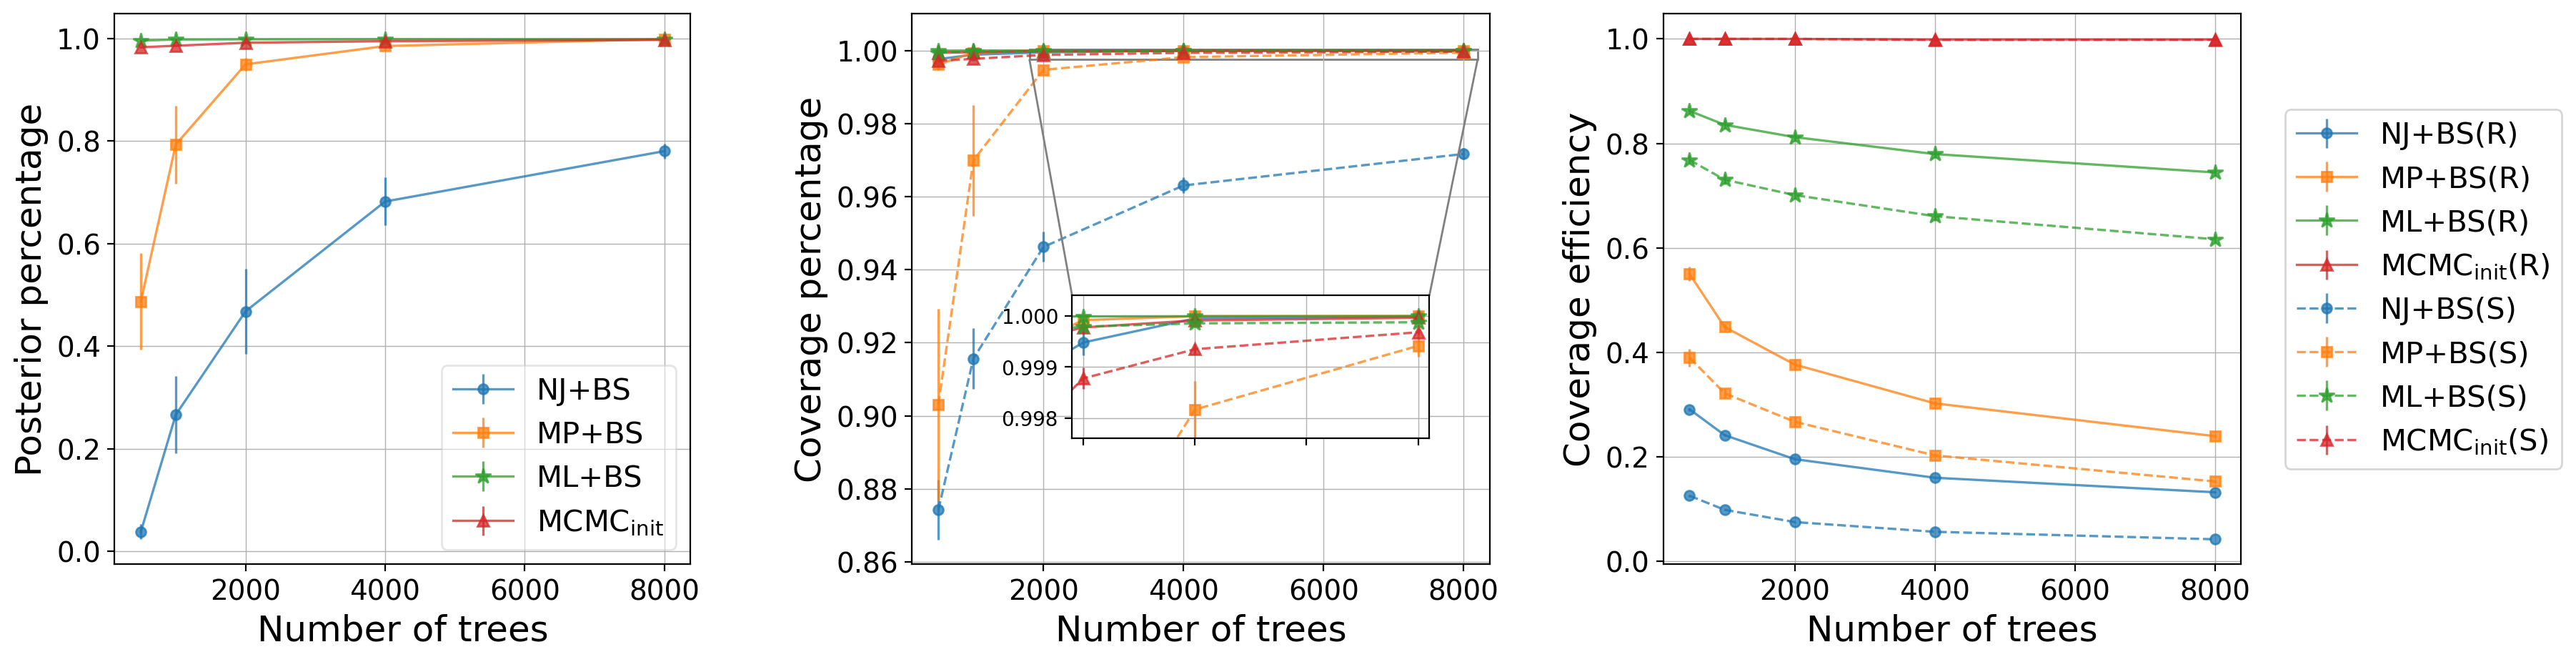

In [40]:
fig = plt.figure(figsize=(15.5,5))
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.02, right=0.28)
ax1 = plt.subplot(gs1[0,0])
ax1.errorbar(n_trees, bs_nj_credit_mean, yerr=bs_nj_credit_std, fmt='-o', markersize=5, linewidth=lw, label='NJ+BS', alpha=0.75)
ax1.errorbar(n_trees, bs_mp_credit_mean, yerr=bs_mp_credit_std, fmt='-s', markersize=5, linewidth=lw, label='MP+BS', alpha=0.75)
ax1.errorbar(n_trees, bs_ml_credit_mean, yerr=bs_ml_credit_std, fmt='-*', markersize=8, linewidth=lw, label='ML+BS', alpha=0.75)
ax1.errorbar(n_trees, init_mcmc_credit_mean, yerr=init_mcmc_credit_std, fmt='-^', markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$', alpha=0.75)
ax1.legend(loc='best', fontsize=15, framealpha=0.5)
ax1.set_ylabel('Posterior percentage', fontsize=18)
ax1.set_xlabel('Number of trees', fontsize=18)
ax1.tick_params(labelsize=14)
ax1.grid(linewidth=0.5)

gs2 = gridspec.GridSpec(1, 2)
gs2.update(left=0.38, right=0.98, wspace=0.3)
ax2 = plt.subplot(gs2[0,0])
ax2.errorbar(n_trees, bs_nj_cover_percent_mean[:,0], yerr=bs_nj_cover_percent_std[:,0], fmt='-o', markersize=5, linewidth=lw, label='NJ+BS(R)', alpha=0.75)
ax2.errorbar(n_trees, bs_mp_cover_percent_mean[:,0], yerr=bs_mp_cover_percent_std[:,0], fmt='-s', markersize=5, linewidth=lw, label='MP+BS(R)', alpha=0.75)
ax2.errorbar(n_trees, bs_ml_cover_percent_mean[:,0], yerr=bs_ml_cover_percent_std[:,0], fmt='-*', markersize=8, linewidth=lw, label='ML+BS(R)', alpha=0.75)
ax2.errorbar(n_trees, init_mcmc_cover_percent_mean[:,0], yerr=init_mcmc_cover_percent_std[:,0], fmt='-^', markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$(R)', alpha=0.75)
ax2.errorbar(n_trees, bs_nj_cover_percent_mean[:,1], yerr=bs_nj_cover_percent_std[:,1], fmt='--o', c=colors[0], markersize=5, linewidth=lw, label='NJ+BS(S)', alpha=0.75)
ax2.errorbar(n_trees, bs_mp_cover_percent_mean[:,1], yerr=bs_mp_cover_percent_std[:,1], fmt='--s', c=colors[1], markersize=5, linewidth=lw, label='MP+BS(S)', alpha=0.75)
ax2.errorbar(n_trees, bs_ml_cover_percent_mean[:,1], yerr=bs_ml_cover_percent_std[:,1], fmt='--*', c=colors[2], markersize=8, linewidth=lw, label='ML+BS(S)', alpha=0.75)
ax2.errorbar(n_trees, init_mcmc_cover_percent_mean[:,1], yerr=init_mcmc_cover_percent_std[:,1], fmt='--^', c=colors[3], markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$(S)', alpha=0.75)
ax2.set_ylabel('Coverage percentage', fontsize=18)
ax2.set_xlabel('Number of trees', fontsize=18)
ax2.set_ylim(top=1.01)
ax2.tick_params(labelsize=14)
ax2.grid(linewidth=0.5)

axins = inset_axes(ax2, 2.5, 1.0, bbox_to_anchor=(0.618, 0.5), bbox_transform=ax1.figure.transFigure)
axins.errorbar(n_trees, bs_nj_cover_percent_mean[:,0], yerr=bs_nj_cover_percent_std[:,0], fmt='-o', markersize=5, linewidth=lw, label='NJ+BS(R)', alpha=0.75)
axins.errorbar(n_trees, bs_mp_cover_percent_mean[:,0], yerr=bs_mp_cover_percent_std[:,0], fmt='-s', markersize=5, linewidth=lw, label='MP+BS(R)', alpha=0.75)
axins.errorbar(n_trees, bs_ml_cover_percent_mean[:,0], yerr=bs_ml_cover_percent_std[:,0], fmt='-*', markersize=8, linewidth=lw, label='ML+BS(R)', alpha=0.75)
axins.errorbar(n_trees, init_mcmc_cover_percent_mean[:,0], yerr=init_mcmc_cover_percent_std[:,0], fmt='-^', markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$(R)', alpha=0.75)
axins.errorbar(n_trees, bs_nj_cover_percent_mean[:,1], yerr=bs_nj_cover_percent_std[:,1], fmt='--o', c=colors[0], markersize=5, linewidth=lw, label='NJ+BS(S)', alpha=0.75)
axins.errorbar(n_trees, bs_mp_cover_percent_mean[:,1], yerr=bs_mp_cover_percent_std[:,1], fmt='--s', c=colors[1], markersize=5, linewidth=lw, label='MP+BS(S)', alpha=0.75)
axins.errorbar(n_trees, bs_ml_cover_percent_mean[:,1], yerr=bs_ml_cover_percent_std[:,1], fmt='--*', c=colors[2], markersize=8, linewidth=lw, label='ML+BS(S)', alpha=0.75)
axins.errorbar(n_trees, init_mcmc_cover_percent_mean[:,1], yerr=init_mcmc_cover_percent_std[:,1], fmt='--^', c=colors[3], markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$(S)', alpha=0.75)
axins.set_xlim([1800, 8200])
axins.set_ylim([0.9976,1.0004])
axins.set_xticklabels([])
axins.grid(linewidth=0.5)

_, pp1, pp2 = mark_inset(ax2, axins, loc1=1, loc2=2, fc="none", ec="0.5")
pp1.loc2 = 4
pp2.loc2 = 3
plt.draw()

ax3 = plt.subplot(gs2[0,1])
ax3.errorbar(n_trees, bs_nj_cover_eff_mean[:,0], yerr=bs_nj_cover_eff_std[:,0], fmt='-o', markersize=5, linewidth=lw, label='NJ+BS(R)', alpha=0.75)
ax3.errorbar(n_trees, bs_mp_cover_eff_mean[:,0], yerr=bs_mp_cover_eff_std[:,0], fmt='-s', markersize=5, linewidth=lw, label='MP+BS(R)', alpha=0.75)
ax3.errorbar(n_trees, bs_ml_cover_eff_mean[:,0], yerr=bs_ml_cover_eff_std[:,0], fmt='-*', markersize=8, linewidth=lw, label='ML+BS(R)', alpha=0.75)
ax3.errorbar(n_trees, init_mcmc_cover_eff_mean[:,0], yerr=init_mcmc_cover_eff_std[:,0], fmt='-^', markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$(R)', alpha=0.75)
ax3.errorbar(n_trees, bs_nj_cover_eff_mean[:,1], yerr=bs_nj_cover_eff_std[:,1], fmt='--o', c=colors[0], markersize=5, linewidth=lw, label='NJ+BS(S)', alpha=0.75)
ax3.errorbar(n_trees, bs_mp_cover_eff_mean[:,1], yerr=bs_mp_cover_eff_std[:,1], fmt='--s', c=colors[1], markersize=5, linewidth=lw, label='MP+BS(S)', alpha=0.75)
ax3.errorbar(n_trees, bs_ml_cover_eff_mean[:,1], yerr=bs_ml_cover_eff_std[:,1], fmt='--*', c=colors[2], markersize=8, linewidth=lw, label='ML+BS(S)', alpha=0.75)
ax3.errorbar(n_trees, init_mcmc_cover_eff_mean[:,1], yerr=init_mcmc_cover_eff_std[:,1], fmt='--^', c=colors[3], markersize=6, linewidth=lw, label=r'$\mathrm{MCMC}_{\mathrm{init}}$(S)', alpha=0.75)
ax3.set_ylabel('Coverage efficiency', fontsize=18)
ax3.set_xlabel('Number of trees', fontsize=18)
ax3.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=15)
ax3.tick_params(labelsize=14)

plt.grid(linewidth=0.5)

plt.show()